In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
from matplotlib.ticker import FuncFormatter

df = pd.read_csv('E:\\myREPO\\Fairness-Decision-Focused-Loss\\Organized-FDFL\\src\\data\\data.csv')
df = df.sample(n=2000,random_state=42)
race_map = {0: 'white', 1: 'black'}
df['race'] = df['race'].map(race_map)

style_palette = {"white": "#ffa600", "black": "#764885"}
style_linestyles = {"white": "solid", "black": "dashed"}

In [88]:
# --- Create other necessary variables for plotting ---
df['cost_t_log'] = np.log1p(df['cost_t'])
df['bps_above_139_ind'] = (df['bps_mean_t'] > 139).astype(int)

In [89]:
df['cost_t_log']

9224      7.901377
18272     8.881975
11457     8.343078
3732      7.550135
38622     6.685861
           ...    
18396     8.476580
5055     10.968216
21496     6.803505
7096      8.131825
31310     0.000000
Name: cost_t_log, Length: 2000, dtype: float64

==============================================================================
# CORE PLOTTING FUNCTIONS
==============================================================================


In [90]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def compute_aggregated_data(df, y_col, x_col):
    """Calculates aggregated means for both percentiles and deciles."""
    df_copy = df.copy()
    df_copy['percentile_int'] = (df_copy.groupby('race')[x_col].rank(pct=True) * 100).astype(int)
    percentile_agg = df_copy.groupby(['race', 'percentile_int'])[y_col].mean().reset_index()
    percentile_agg.rename(columns={'percentile_int': 'percentile'}, inplace=True)
    df_copy['decile_bin'] = pd.qcut(df_copy[x_col], q=10, labels=False, duplicates='drop')
    decile_agg = df_copy.groupby(['race', 'decile_bin'])[y_col].agg(['mean', get_se]).reset_index()
    decile_agg.rename(columns={'get_se': 'se'}, inplace=True)
    decile_agg['ci_lower'] = decile_agg['mean'] - 1.96 * decile_agg['se']
    decile_agg['ci_upper'] = decile_agg['mean'] + 1.96 * decile_agg['se']
    decile_agg['decile_centered'] = (decile_agg['decile_bin'] * 10) + 5
    return percentile_agg, decile_agg

def create_r_style_plot(df, y_col, x_col, title, y_label, save_path, span, use_log_scale=False, y_ticks=None):
    """Creates and saves a single plot that closely mimics the R ggplot2 output, with control over LOESS span."""
    
    percentile_data, decile_data = compute_aggregated_data(df, y_col, x_col)
    
    if use_log_scale:
        epsilon = 0.001
        percentile_data[y_col] = np.log(percentile_data[y_col] + epsilon)
        decile_data[['mean', 'ci_lower', 'ci_upper']] = np.log(decile_data[['mean', 'ci_lower', 'ci_upper']] + epsilon)
        y_ticks_log = np.log(y_ticks)
        vlocation_threshold = np.log(50000)
    else:
        y_min, y_max = percentile_data[y_col].min(), percentile_data[y_col].max()
        vlocation_threshold = y_min + 0.8 * (y_max - y_min)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')

    for race in df['race'].unique():
        color, linestyle = style_palette[race], style_linestyles[race]
        p_data = percentile_data[percentile_data['race'] == race].sort_values('percentile')
        d_data = decile_data[decile_data['race'] == race]

        # 1. geom_point(shape = 4) for percentiles
        ax.scatter(x='percentile', y=y_col, data=p_data, marker='x', s=20, color=color, alpha=0.8)

        # 2. geom_smooth(se = F, span = ...) - Manual calculation
        # The `lowess` function returns smoothed y-values and the corresponding x-values.
        smoothed = lowess(p_data[y_col], p_data['percentile'], frac=span)
        ax.plot(smoothed[:, 0], smoothed[:, 1], color=color, linestyle=linestyle, label=race)

        # 3. geom_pointrange() for deciles
        ax.errorbar(x='decile_centered', y='mean', data=d_data, yerr=(d_data['ci_upper'] - d_data['ci_lower']) / 2,
                    fmt='o', markersize=7, color=color, ecolor=color, capsize=0,
                    elinewidth=1.5, markeredgecolor='white', markeredgewidth=0.5)

    ax.set_title(title, loc='center', fontsize=14, weight='bold')
    ax.set_xlabel(f"Percentile of {x_col.replace('_', ' ').title()}", fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlim(-2, 102)

    if use_log_scale:
        ax.set_yticks(y_ticks_log)
        formatter = FuncFormatter(lambda y, _: f'${int(np.exp(y)):,}')
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(bottom=np.log(700), top=np.log(100000))
    
    ax.axvline(97, color='black', linestyle='--', linewidth=1)
    ax.text(96, vlocation_threshold, 'Defaulted into program', ha='right', va='center', fontsize=9, color='black')
    ax.axvline(55, color='dimgray', linestyle='--', linewidth=1)
    ax.text(54, vlocation_threshold, 'Referred for screen', ha='right', va='center', fontsize=9, color='dimgray')

    # fig.legend(loc='lower center', ncol=len(df['race'].unique()), title="Race", bbox_to_anchor=(0.5, -0.05))


# Figure

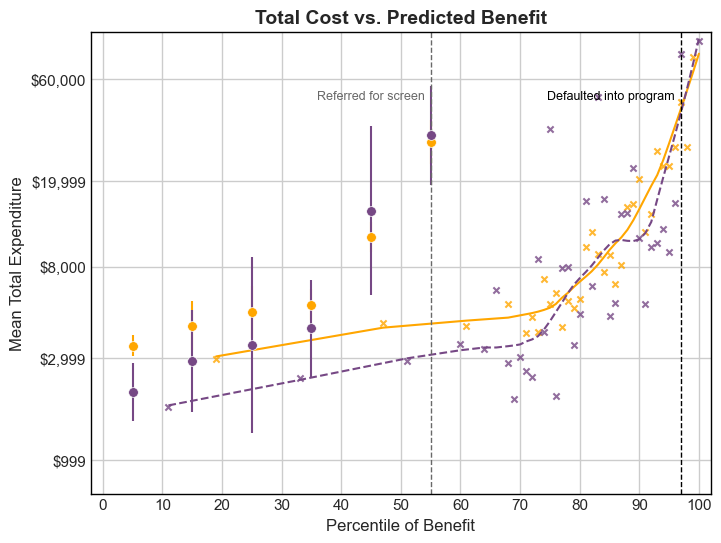

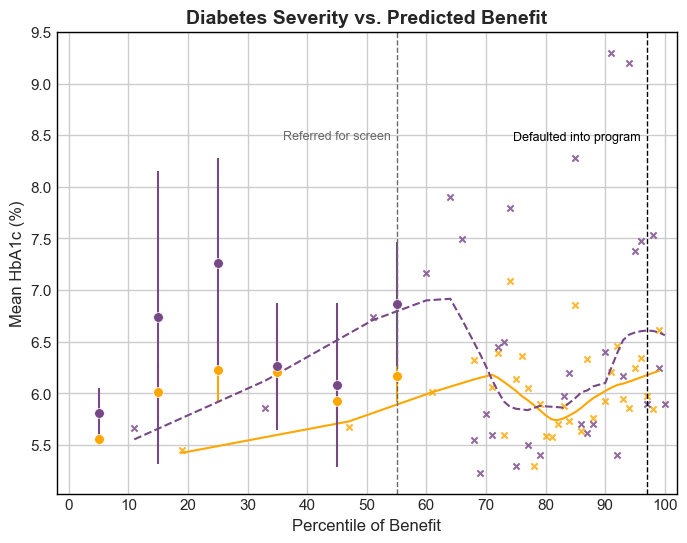

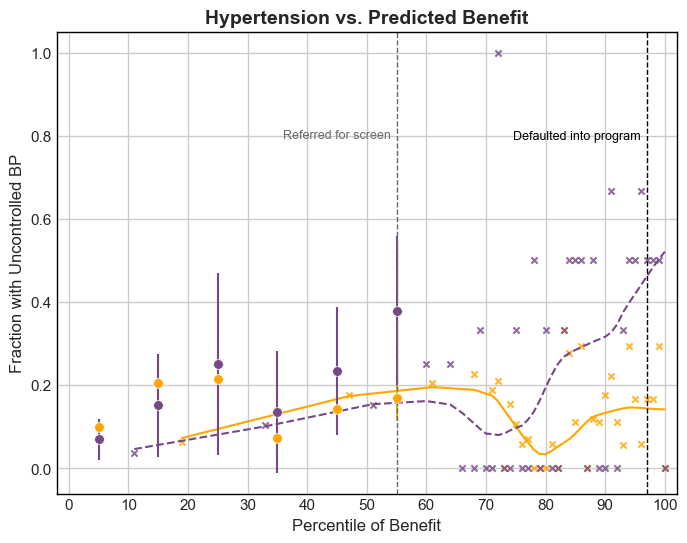

c:\Users\14469\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


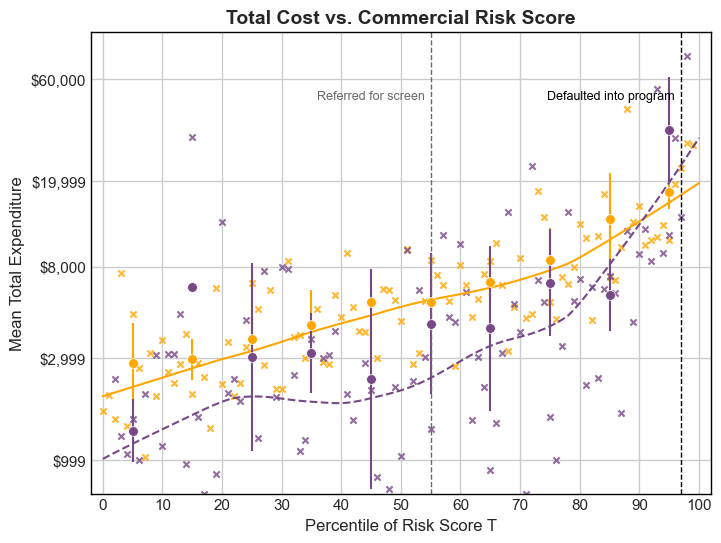

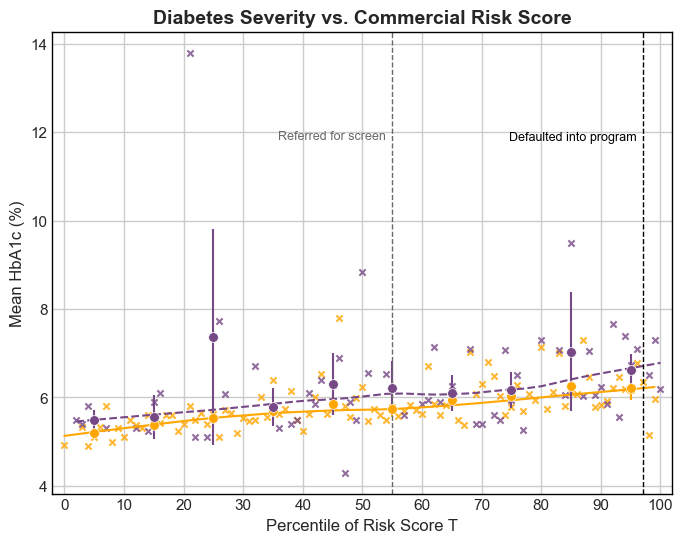

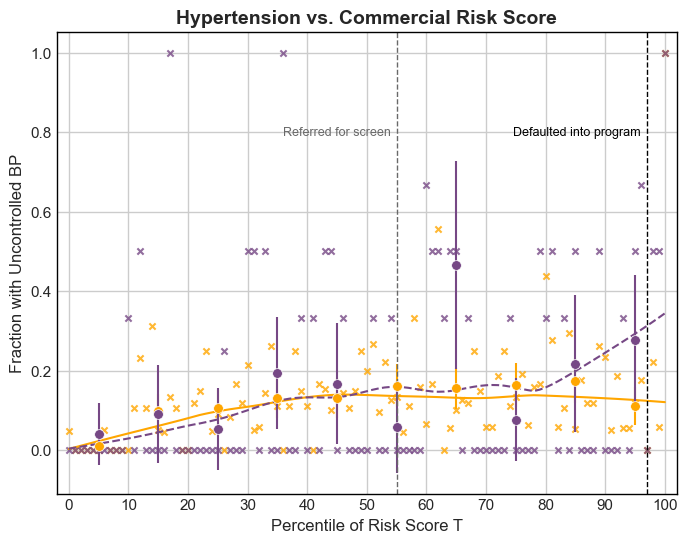


All plots have been generated and saved.


In [91]:
cost_ticks = [1000, 3000, 8000, 20000, 60000]

plots_to_generate = [
    # Analyses vs. Predicted Benefit
    {'y_col': 'cost_t', 'x_col': 'benefit', 'title': 'Total Cost vs. Predicted Benefit', 'y_label': 'Mean Total Expenditure', 'use_log_scale': True, 'y_ticks': cost_ticks,'span': 0.45},
    {'y_col': 'ghba1c_mean_t', 'x_col': 'benefit', 'title': 'Diabetes Severity vs. Predicted Benefit', 'y_label': 'Mean HbA1c (%)','span': 0.45},
    {'y_col': 'bps_above_139_ind', 'x_col': 'benefit', 'title': 'Hypertension vs. Predicted Benefit', 'y_label': 'Fraction with Uncontrolled BP','span': 0.45},
    
    # Analyses vs. Commercial Risk Score
    {'y_col': 'cost_t', 'x_col': 'risk_score_t', 'title': 'Total Cost vs. Commercial Risk Score', 'y_label': 'Mean Total Expenditure', 'use_log_scale': True, 'y_ticks': cost_ticks,'span': 0.45},
    {'y_col': 'ghba1c_mean_t', 'x_col': 'risk_score_t', 'title': 'Diabetes Severity vs. Commercial Risk Score', 'y_label': 'Mean HbA1c (%)','span': 0.45},
    {'y_col': 'bps_above_139_ind', 'x_col': 'risk_score_t', 'title': 'Hypertension vs. Commercial Risk Score', 'y_label': 'Fraction with Uncontrolled BP','span': 0.45},
]

# Loop through the definitions and create each plot
for plot_params in plots_to_generate:
    create_r_style_plot(
        df=df,
        y_col=plot_params['y_col'],
        x_col=plot_params['x_col'],
        title=plot_params['title'],
        y_label=plot_params['y_label'],
        save_path=None,  # Do not save
        use_log_scale=plot_params.get('use_log_scale', False),
        span=plot_params['span'],
        y_ticks=plot_params.get('y_ticks')
    )
    plt.show()

print("\nAll plots have been generated and saved.")


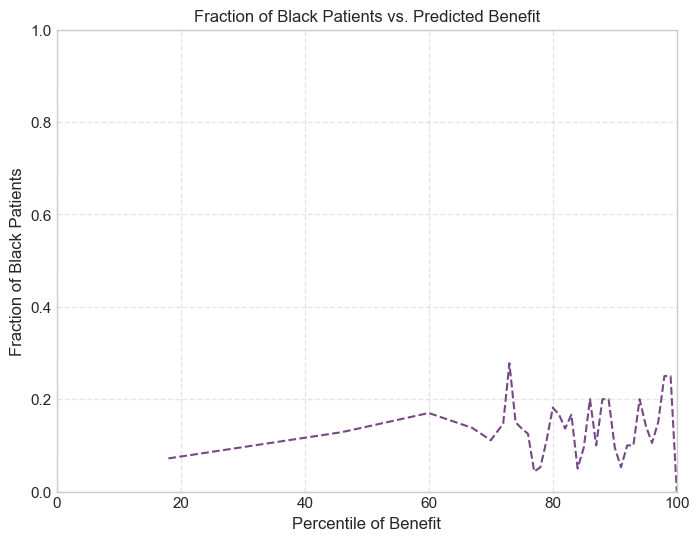

In [93]:
# Calculate the percentage of black patients in each benefit percentile
df['benefit_percentile'] = (df['benefit'].rank(pct=True) * 100).astype(int)
black_pct = (
    df.groupby('benefit_percentile')['race']
    .apply(lambda x: (x == 'black').mean())
    .reset_index(name='black_percentage')
)

plt.figure(figsize=(8, 6))
plt.plot(black_pct['benefit_percentile'], black_pct['black_percentage'], color=style_palette['black'], linestyle=style_linestyles['black'])
plt.xlabel('Percentile of Benefit')
plt.ylabel('Fraction of Black Patients')
plt.title('Fraction of Black Patients vs. Predicted Benefit')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()